<a href="https://colab.research.google.com/github/nourhanhamdyebrahim123/LULC-classification/blob/main/LULC_classification_Ph_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()  # This will open a file picker


Saving FPN_50_epochs.hdf5 to FPN_50_epochs.hdf5


In [ ]:
pip install patchify

In [ ]:
pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import scipy.signal
from tqdm import tqdm
from keras.models import load_model
import gc

import cv2

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical

scaler = MinMaxScaler()

import tensorflow as tf

AttributeError: module 'keras.utils' has no attribute 'generic_utils'

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
import os
import numpy as np
import scipy.signal
from tqdm import tqdm
from keras.models import load_model
import gc

import cv2

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical

scaler = MinMaxScaler()

import tensorflow as tf

Segmentation Models: using `tf.keras` framework.


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth (don't pre-allocate all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Optional: also set a hard memory limit on the first GPU (MiB)
        # tf.config.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.VirtualDeviceConfiguration(memory_limit=14000)])  # e.g. 14GB
    except Exception as e:
        print("Could not set GPU configs:", e)

In [ ]:
pip install keras_unet_collection

In [ ]:
import glob
import sys
from datetime import datetime
from tensorflow import keras
import tifffile as tif
from keras_unet_collection import models, losses
from sklearn.metrics import f1_score, jaccard_score



In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'

for infile in sorted(glob.glob('*.tif')):
    print ("Current File Being Processed is: " + infile)


In [ ]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [ ]:
model = load_model(r"FPN_50_epochs.hdf5",compile = False)
# size of patches
patch_size = 256
n_classes = 4
subset_dataset = []
classified_dataset = []
#classified_dataset = []
#test_directory = 'E:\\Projects_to_be_applied\\LULC_change_in_2050\\Delta_FPN\\Trial_resnet_backbone\\8-batch-size_50-epochs\\Testing_Data\\'
scaler = MinMaxScaler()
results_list =[]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your dataset folder in Drive
test_directory = "/content/drive/My Drive/LULC_classification/Testing_Data"

In [ ]:
# List files
print(os.listdir(test_directory))

['masks', 'images']


In [ ]:
def label_to_rgb(predicted_img):

    Cultivated = (0,255,0)
    Water = (0,0,255)
    Builtup = (255,0,0)
    Bareland = (255,255,0)


    segmented_img = np.empty((predicted_img.shape[0], predicted_img.shape[1], 3))
    segmented_img[(predicted_img == 0)] = Cultivated
    segmented_img[(predicted_img == 1)] = Water
    segmented_img[(predicted_img == 2)] = Builtup
    segmented_img[(predicted_img == 3)] = Bareland

    segmented_img = segmented_img.astype(np.uint8)
    return (segmented_img)

In [ ]:
for path, subdirs, files in os.walk(test_directory):
    print("Hello")
    print(path)
    # dirname = path.split(os.path.sep)[-1]
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    if dirname == 'images':
        print("hello_00")
        subsets = os.listdir(path)
        for i, subset_name in enumerate(subsets):
            print("hello_01")
            if subset_name.endswith("tif"):
                print("hello_02")
                print(path+"/"+subset_name)
                subset = tif.imread(path+"/"+subset_name)
                gror_red = subset[:,:,1]
                redor_NIR = subset[:,:,2]
                NIRor_therm = subset[:,:,3]
                three_channel_img = cv2.merge((gror_red, redor_NIR, NIRor_therm))
                input_img = scaler.fit_transform(three_channel_img.reshape(-1,three_channel_img.shape[-1])).reshape(three_channel_img.shape)
                subset_dataset.append(input_img)


print(len(subset_dataset))


Hello
/content/drive/My Drive/LULC_classification/Testing_Data
Testing_Data
Hello
/content/drive/My Drive/LULC_classification/Testing_Data/masks
masks
Hello
/content/drive/My Drive/LULC_classification/Testing_Data/images
images
hello_00
hello_01
hello_02
/content/drive/My Drive/LULC_classification/Testing_Data/images/subset_03.tif
hello_01
hello_02
/content/drive/My Drive/LULC_classification/Testing_Data/images/subset_04.tif
hello_01
hello_01
2


In [ ]:
for path, subdirs, files in os.walk(test_directory):
     print(path)
     dirname = path.split(os.path.sep)[-1]
     if dirname == 'masks':
         masks = os.listdir(path)
         for i, classified_name in enumerate(masks):
             if classified_name.endswith("tif"):
                 print(path+"/"+classified_name)
                 classified = tif.imread(path+"/"+classified_name)
                 classified_dataset.append(classified)


print(len(classified_dataset))

/content/drive/My Drive/LULC_classification/Testing_Data
/content/drive/My Drive/LULC_classification/Testing_Data/masks
/content/drive/My Drive/LULC_classification/Testing_Data/masks/classified_03.tif
/content/drive/My Drive/LULC_classification/Testing_Data/masks/classified_04.tif
/content/drive/My Drive/LULC_classification/Testing_Data/images
2


k of ground 0
k of masked 0


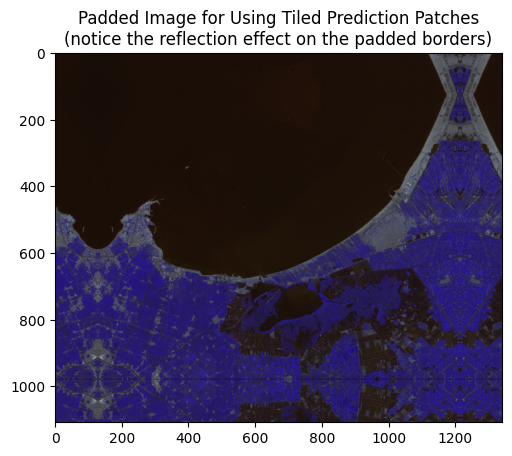

  0%|          | 0/8 [00:00<?, ?it/s]

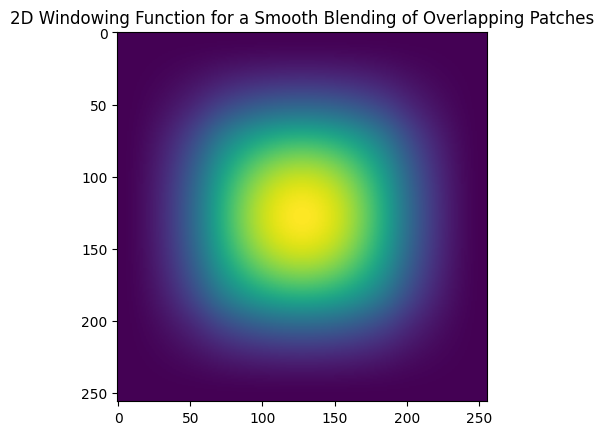

2/2 ━━━━━━━━━━━━━━━━━━━━ 88s 43s/step


 12%|█▎        | 1/8 [02:24<16:51, 144.53s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 38s/step


 25%|██▌       | 2/8 [04:48<14:25, 144.25s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step


 38%|███▊      | 3/8 [06:12<09:43, 116.74s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step


 50%|█████     | 4/8 [07:37<06:55, 103.98s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 39s/step


 62%|██████▎   | 5/8 [09:01<04:50, 96.87s/it] 

2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 37s/step


 75%|███████▌  | 6/8 [10:25<03:05, 92.62s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 39s/step


 88%|████████▊ | 7/8 [11:49<01:29, 89.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step


100%|██████████| 8/8 [13:14<00:00, 99.27s/it]


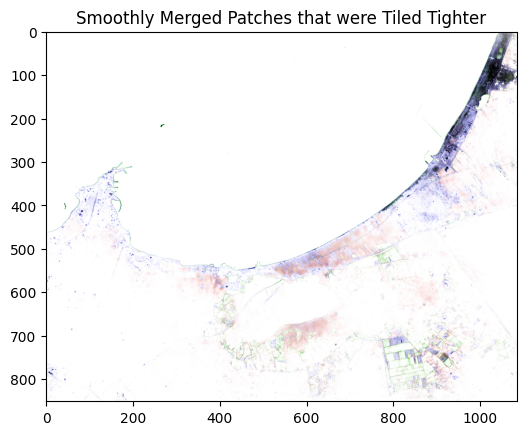

f1 score value is is:  0.8758458229642089
jaccard index value is is:  0.7874100567112301
Execution time is:  0:13:16.133168


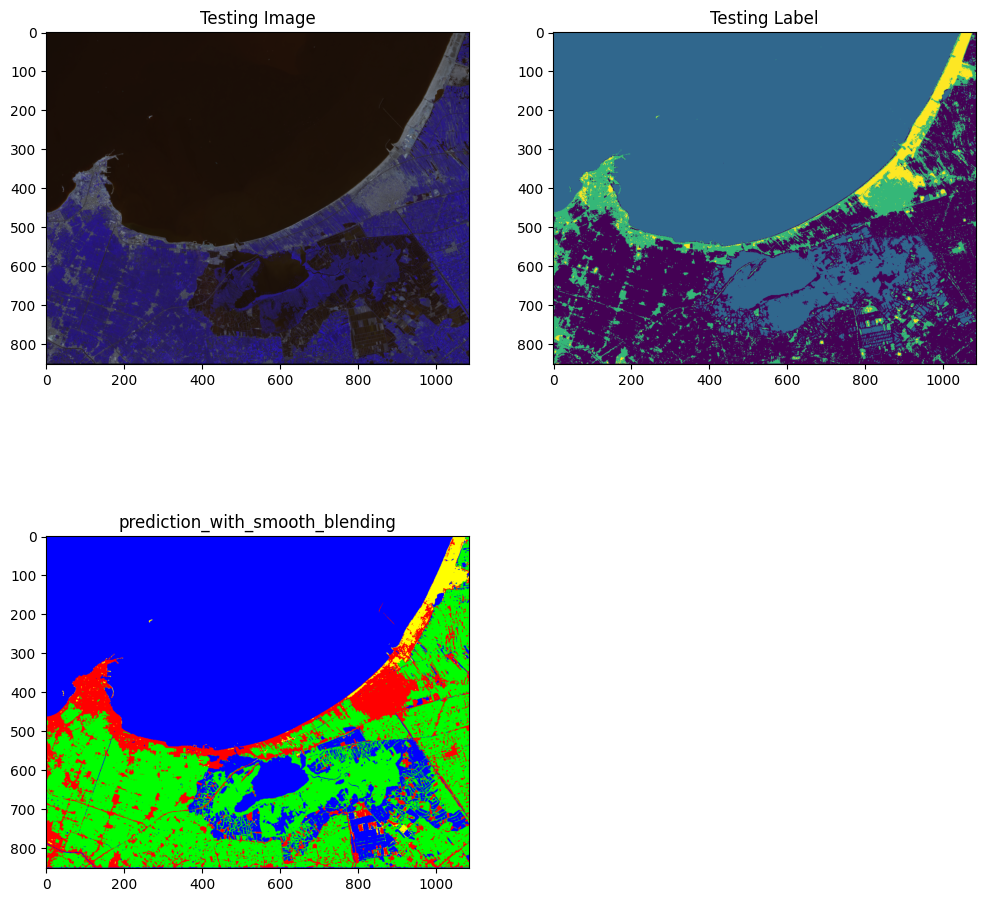

k of ground 1
k of masked 1


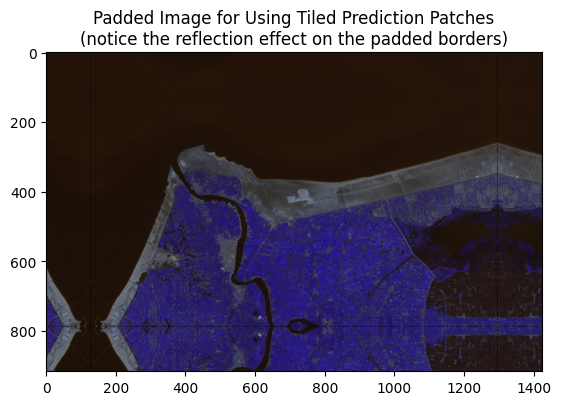

  0%|          | 0/8 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 34s/step


 12%|█▎        | 1/8 [01:16<08:54, 76.36s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 34s/step


 25%|██▌       | 2/8 [02:32<07:37, 76.27s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 34s/step


 38%|███▊      | 3/8 [03:49<06:22, 76.48s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 34s/step


 50%|█████     | 4/8 [05:05<05:06, 76.50s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 34s/step


 62%|██████▎   | 5/8 [06:29<03:57, 79.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 36s/step


 75%|███████▌  | 6/8 [07:46<02:36, 78.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 36s/step


 88%|████████▊ | 7/8 [09:10<01:20, 80.10s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 35s/step


100%|██████████| 8/8 [10:32<00:00, 79.00s/it]


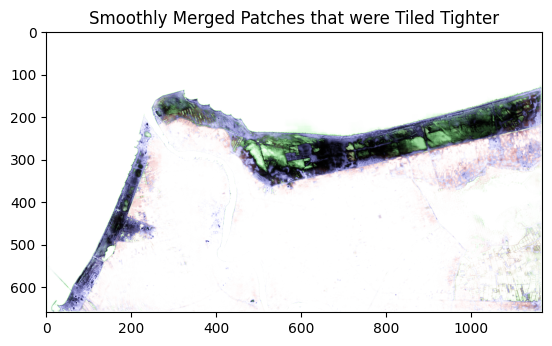

f1 score value is is:  0.8690613300279096
jaccard index value is is:  0.7828504904001735
Execution time is:  0:10:34.132362


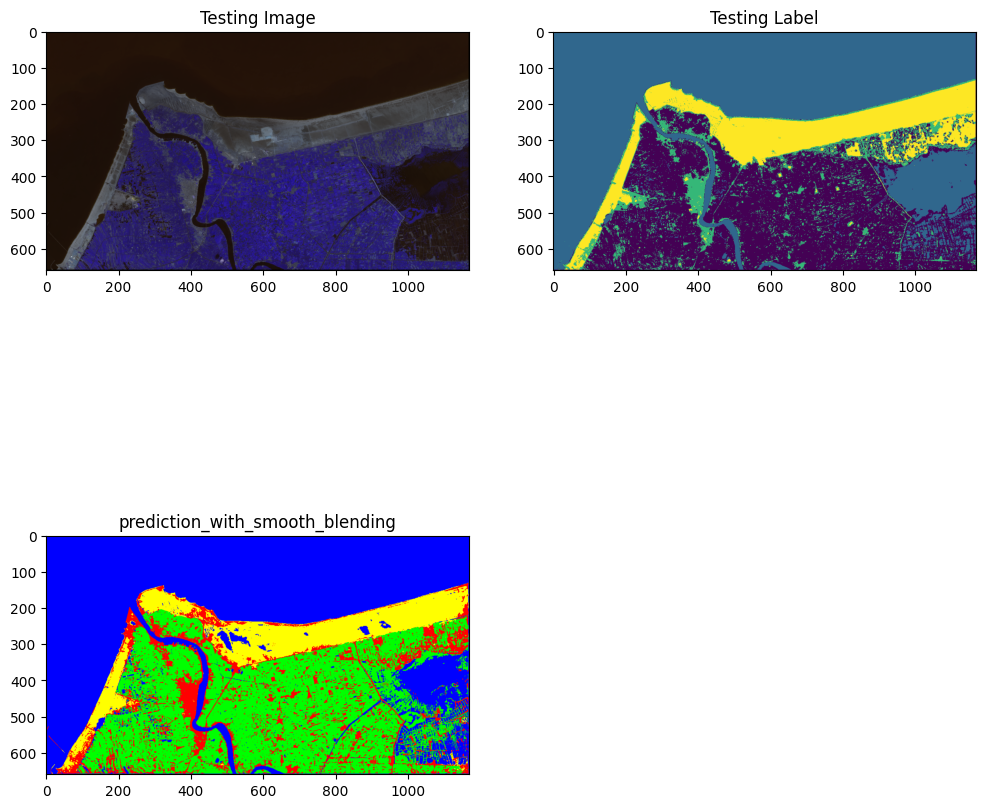

In [ ]:
for k in range(len(subset_dataset)):
    ground_truth = subset_dataset[k]
    print ("k of ground", k)
    masked_img = classified_dataset[k]
    print ("k of masked", k)
    start = datetime.now()

   # predict using smooth blending
    predictions_smooth = predict_img_with_smooth_windowing(
                                       subset_dataset[k],
                                       window_size = patch_size,
                                       subdivisions=2,
                                       nb_classes=n_classes,
                                       pred_func=(
                                           lambda img_batch_subdiv: model.predict((img_batch_subdiv))
                                      )
                )
    final_prediction = np.argmax(predictions_smooth, axis=2)
    masked_img_flat = masked_img.flatten()

    # ground_truth_flat = ground_truth.flatten()
    predicted_img_flat = final_prediction.flatten()
    f1_score_value = f1_score(masked_img_flat, predicted_img_flat, average="weighted")
    jaccard_index = jaccard_score(masked_img_flat, predicted_img_flat, average="weighted")
    prediction_with_smooth_blending = label_to_rgb(final_prediction)
    print("f1 score value is is: ", f1_score_value)
    print("jaccard index value is is: ", jaccard_index)







    stop = datetime.now()
    #Execution time of the model
    Inference_time = stop-start
    print("Execution time is: ", Inference_time)




    #plot and save results

    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(ground_truth)


    plt.subplot(222)
    plt.title('Testing Label')
    plt.imshow(masked_img)

    plt.subplot(223)
    plt.title('prediction_with_smooth_blending')
    plt.imshow(prediction_with_smooth_blending)

    plt.show()

In [ ]:
    tif.imwrite('prediction_with_smooth_blending_'+str(k)+'.tif', prediction_with_smooth_blending)
